# DenseNet
相比ResNet，DenseNet提出了一个更激进的密集连接机制：即互相连接所有的层，具体来说就是每个层都会接受其前面所有层作为其额外的输入。

## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 超参

In [2]:
EPOCHS = 10
BATCH_SIZE = 64
VERBOSE = 1
IMAGE_SIZE = 224
VALIDATION_SPLIT = 0.2

## 导入数据集

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

## 定义模型

In [5]:
class BottleNeck(keras.layers.Layer):
    def __init__(self, growth_rate, drop_rate):
        super(BottleNeck, self).__init__()
        self.bn1 = keras.layers.BatchNormalization()
        self.conv1 = keras.layers.Conv2D(filters=4 * growth_rate, kernel_size=(1, 1), strides=1, padding="same")
        self.bn2 = keras.layers.BatchNormalization()
        
        self.conv2 = keras.layers.Conv2D(filters=growth_rate, kernel_size=(3, 3), strides=1, padding="same")
        self.dropout = keras.layers.Dropout(rate=drop_rate)
        
        self.listLayers = [self.bn1, keras.layers.Activation("relu"), self.conv1, 
                           self.bn2, keras.layers.Activation("relu"), self.conv2, self.dropout]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = keras.layers.concatenate([x,y], axis=-1)
        return y

In [6]:
class DenseBlock(keras.layers.Layer):
    def __init__(self, num_layers, growth_rate, drop_rate=0.5):
        super(DenseBlock, self).__init__()
        self.num_layers = num_layers
        self.growth_rate = growth_rate
        self.drop_rate = drop_rate
        self.listLayers = []
        for _ in range(num_layers):
            self.listLayers.append(BottleNeck(growth_rate=self.growth_rate, drop_rate=self.drop_rate))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

In [7]:
class TransitionLayer(keras.layers.Layer):
    def __init__(self, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = keras.layers.BatchNormalization()
        self.conv = keras.layers.Conv2D(filters=out_channels, kernel_size=(1, 1), strides=1, padding="same")
        self.pool = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
    def call(self, inputs):
        x = self.bn(inputs)
        x = keras.activations.relu(x)
        x = self.conv(x)
        x = self.pool(x)
        return x

In [8]:
class DenseNet(tf.keras.Model):
    def __init__(self, num_init_features, growth_rate, block_layers, compression_rate, drop_rate):
        super(DenseNet, self).__init__()
        self.conv = keras.layers.Conv2D(filters=num_init_features,kernel_size=(7, 7), strides=2, padding="same")
        self.bn = keras.layers.BatchNormalization()
        self.pool = keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        
        self.num_channels = num_init_features
        self.dense_block_1 = DenseBlock(num_layers=block_layers[0], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[0]
        self.num_channels = compression_rate * self.num_channels
        self.transition_1 = TransitionLayer(out_channels=int(self.num_channels))
        self.dense_block_2 = DenseBlock(num_layers=block_layers[1], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[1]
        self.num_channels = compression_rate * self.num_channels
        self.transition_2 = TransitionLayer(out_channels=int(self.num_channels))
        self.dense_block_3 = DenseBlock(num_layers=block_layers[2], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[2]
        self.num_channels = compression_rate * self.num_channels
        self.transition_3 = TransitionLayer(out_channels=int(self.num_channels))
        self.dense_block_4 = DenseBlock(num_layers=block_layers[3], growth_rate=growth_rate, drop_rate=drop_rate)
        
        self.avgpool = keras.layers.GlobalAveragePooling2D()
        self.fc = keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.keras.activations.relu(x)
        x = self.pool(x)

        x = self.dense_block_1(x)
        x = self.transition_1(x)
        x = self.dense_block_2(x)
        x = self.transition_2(x)
        x = self.dense_block_3(x)
        x = self.transition_3(x,)
        x = self.dense_block_4(x)

        x = self.avgpool(x)
        x = self.fc(x)

        return x

In [9]:
model = DenseNet(num_init_features=64, growth_rate=32, block_layers=[6,12,24,16], compression_rate=0.5, drop_rate=0)

## 设置优化器和损失函数

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

## 开始训练

In [11]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 61s 1ms/sample - loss: 0.5012 - accuracy: 0.8202 - val_loss: 0.3577 - val_accuracy: 0.8659
Epoch 2/10
48000/48000 [==============================] - 47s 982us/sample - loss: 0.3128 - accuracy: 0.8852 - val_loss: 0.3206 - val_accuracy: 0.8785
Epoch 3/10
48000/48000 [==============================] - 47s 986us/sample - loss: 0.4094 - accuracy: 0.8635 - val_loss: 0.3714 - val_accuracy: 0.8687
Epoch 4/10
48000/48000 [==============================] - 47s 984us/sample - loss: 0.3382 - accuracy: 0.8814 - val_loss: 0.2877 - val_accuracy: 0.8966
Epoch 5/10
48000/48000 [==============================] - 47s 985us/sample - loss: 0.2656 - accuracy: 0.9020 - val_loss: 0.2597 - val_accuracy: 0.9042
Epoch 6/10
48000/48000 [==============================] - 48s 995us/sample - loss: 0.2466 - accuracy: 0.9117 - val_loss: 0.2666 - val_accuracy: 0.9024
Epoch 7/10
48000/48000 [======================

## 绘制梯度下降图

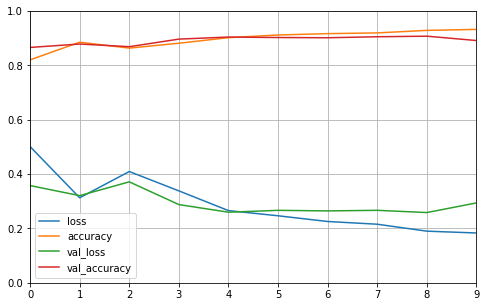

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

## 测试训练好的模型

In [13]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 6s 608us/sample - loss: 0.3065 - accuracy: 0.8868


[0.3064675438404083, 0.88680005]

## 保存模型 

In [14]:
model.save_weights('./save/save_weights/model_weights.h5')